# DATASCI 207: Applied Machine Learning - Final Project
## <span style="color:blue"> Scott Abramson, Brett Brandom, Maria Jose Healey, Yidai Yao </span>

### <span style="color:chocolate"> Pawpularity:Predicting Engagement with a Pet's Profile Based on the Photograph for that Profile.  </span>

#### ``Introduction``

Have you ever wondered how much a captivating picture can influence your decision to adopt or facilitate the adoption of an animal? In the world of the animal welfare, where countless of stray animals are suffering on the streets or in shelters every day, the power of a single image extends beyond aesthetics – it serves as a potential lifeline.
PetFinder.my is Malaysia’s leading animal welfare platform and it collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare. Currently it analyzes cuteness and other factors to rank animals images, which is still in an experimental stage with rooms for improvements.

#### ``Objective``

With the rise of data science, we aim to help by predicting the appealingness of an image through the "Pawpularity" project to hopefully increase the chances of finding caring homes for these rescue animals. By analyzing both raw images and the metadata, we seek to enhance PetFinder.my's existing approach and provide actionable insights to increase adoption rates. Through this endeavor, we strive to not only improve the fortunes of individual animals but also contribute to the broader cause of animal welfare worldwide.

#### ``Data``

The data was obtained from kaggle: https://www.kaggle.com/competitions/petfinder-pawpularity-score

The dataset comprises both images and tabular data (hand-labeled metadata for each photo). 
The Pawpularity Score is derived from each pet profile's page view statistics at the listing pages, using an algorithm that normalizes the traffic data across different pages, platforms (web & mobile) and various metrics.

The training Data is composed of a train folder and a csv file. The train folder contains training set photos of the form {id}.jpg, where {id} is a unique Pet Profile ID. Whereas, the train.csv contains the metadata for each photo in the training set as well as the target, the photo's Pawpularity score. The Id column gives the photo's unique Pet Profile ID corresponding the photo's file name.

Each photo in the metadata is labeled with the value of 1 (Yes) or 0 (No) for each of the following features: 

- Focus - Pet stands out against uncluttered background, not too close / far.

- Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.

- Face - Decently clear face, facing front or near-front.

- Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).

- Action - Pet in the middle of an action (e.g., jumping).

- Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.

- Group - More than 1 pet in the photo.

- Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).

- Human - Human in the photo.

- Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.

- Info - Custom-added text or labels (i.e. pet name, description).

- Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.

### Step 1: Import libraries

In [1]:

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras

import sklearn
from sklearn.model_selection import train_test_split
# baseline classifier
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# random forest
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

import os 
import cv2
import glob
    
%matplotlib inline


In [2]:
path = './'

### Step 2: Read Data

In [3]:
# Load images' paths
train_images = os.listdir(path + 'train')
train_df = pd.read_csv(path + 'train.csv')

train_df = train_df.set_index('Id')
file_names = []
labels = []
# metadata
metadata = []

for index in train_df.index:
    file_name = path + 'train/' + index + '.jpg'
    label = train_df.loc[index]['Pawpularity']
    file_names.append(file_name)
    labels.append(label/1.0)
    
    # metadata
    metadata_row = train_df.loc[index][['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur']].to_numpy()
    metadata.append(metadata_row)
    
   
    

# print number of images
print("Number of images: ", len(file_names))

Number of images:  9912


In [4]:
# tabular data
train_df = train_df.reset_index()
train_df

Id  Subject Focus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0              0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db              0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246              0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2              0     0     0     1   
...                                ...            ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57              0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45              0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20              0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a              0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  
0              63  
1              42  
2              28  
3              15  
4              72  
...           ...  
9907           15  
9908           70  
9909           20  
9910           20  
9911           30  

[9912 rows x 14 columns]

### Step 3: EDA

#### Images

Display images in their original shape dimensions

In [5]:
# load images
images = []
for i in range (len(file_names)):
    img= load_img(file_names[i]) # loads an image from the specified file
    images.append(img)

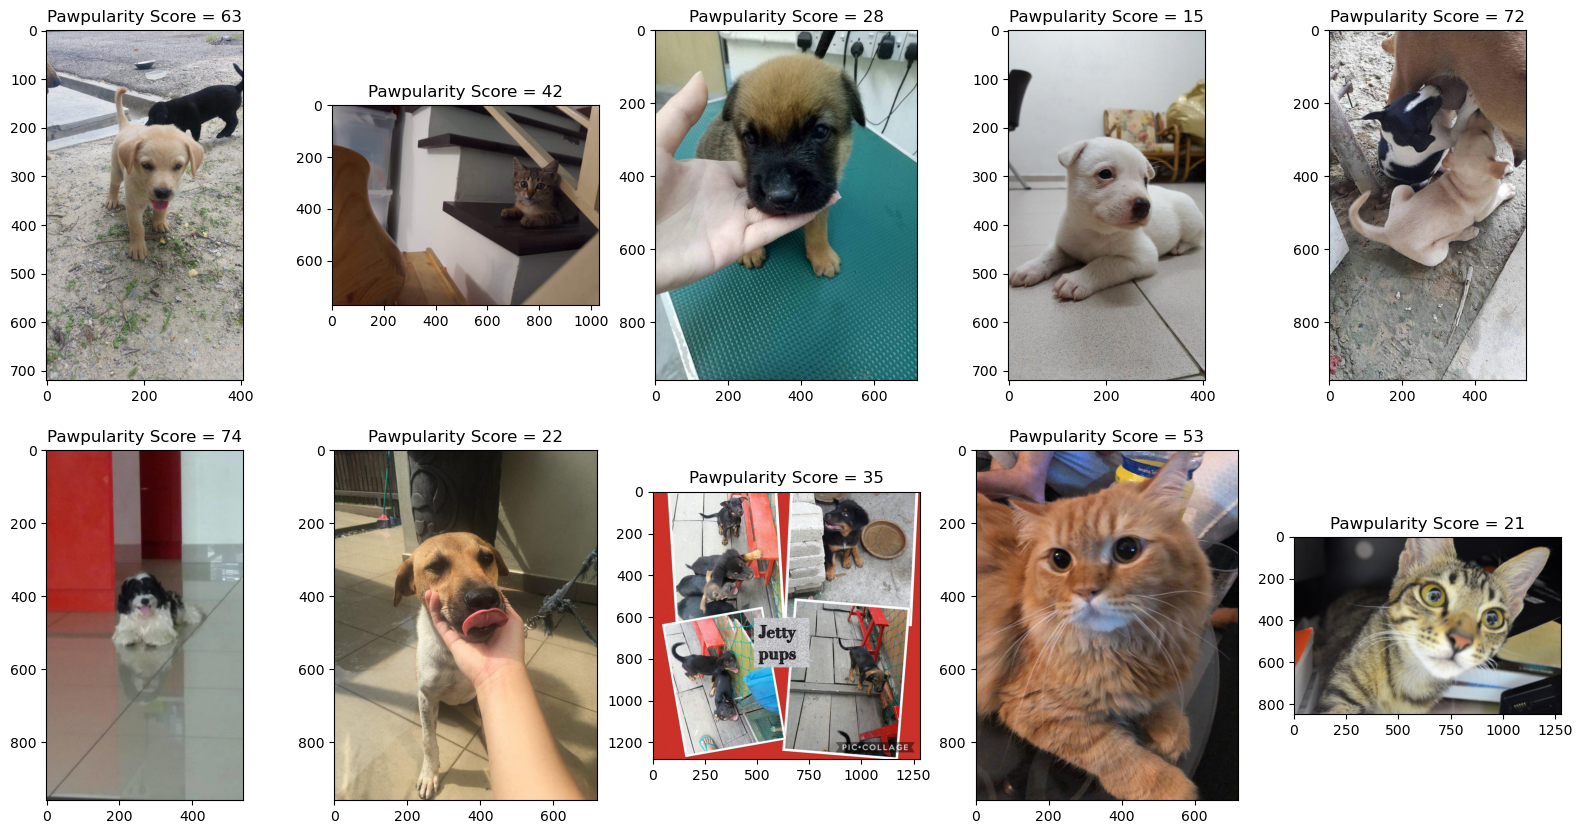

In [6]:
# Display 10 images in their original shape
index=0
num_rows=2
num_cols=5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))
for i in range(num_rows):
    for j in range(num_cols):
        axs[i,j].imshow(images[index])
        axs[i,j].title.set_text('Pawpularity Score = ' + str(train_df['Pawpularity'][index]))
        index+=1
plt.show()

In [7]:
# Checking first 20 images' shape dimensions
for i in range( len(images) ):
    n_shape= np.array(images[i])
    print(f"{i}" + " Image shape ", n_shape.shape)
    if i == 20:
        break

0 Image shape  (720, 405, 3)
1 Image shape  (774, 1032, 3)
2 Image shape  (960, 720, 3)
3 Image shape  (720, 405, 3)
4 Image shape  (960, 540, 3)
5 Image shape  (960, 540, 3)
6 Image shape  (960, 720, 3)
7 Image shape  (1280, 1280, 3)
8 Image shape  (960, 720, 3)
9 Image shape  (847, 1279, 3)
10 Image shape  (1280, 1280, 3)
11 Image shape  (720, 405, 3)
12 Image shape  (960, 540, 3)
13 Image shape  (960, 720, 3)
14 Image shape  (638, 581, 3)
15 Image shape  (960, 720, 3)
16 Image shape  (960, 1280, 3)
17 Image shape  (647, 648, 3)
18 Image shape  (960, 528, 3)
19 Image shape  (960, 720, 3)
20 Image shape  (569, 538, 3)


#### Identify Duplicate Images
Duplicate images were found using imagehash and Pytorch (based on https://www.kaggle.com/code/schulta/petfinder-identify-duplicates-and-share-findings )

Code not included in this notebook because of version incompatibilities with TensorFlow

#### Create a new dataset that excludes duplicates

In [8]:
# Create list of duplicate Ids
dup_ids = ['6dc1ae625a3bfb50571efedc0afc297c','dbc47155644aeb3edd1bd39dba9b6953','bf8501acaeeedc2a421bac3d9af58bb7','fe47539e989df047507eaa60a16bc3fd',
           'bca6811ee0a78bdcc41b659624608125', '373c763f5218610e9b3f82b12ada8ae5', '264845a4236bc9b95123dde3fb809a88', '41c85c2c974cc15ca77f5ababb652f84',
           '6cb18e0936faa730077732a25c3dfb94', '902786862cbae94e890a090e5700298b', '9a0238499efb15551f06ad583a6fa951','6ae42b731c00756ddd291fa615c822a1',
           'b956edfd0677dd6d95de6cb29a85db9c', 'dd042410dc7f02e648162d7764b50900', 'c504568822c53675a4f425c8e5800a36', '8ffde3ae7ab3726cff7ca28697687a42',
           '67e97de8ec7ddcda59a58b027263cdcc', '9b3267c1652691240d78b7b3d072baf3', '763d66b9cf01069602a968e573feb334', 'c25384f6d93ca6b802925da84dfa453e',
           'b49ad3aac4296376d7520445a27726de', '988b31dd48a1bc867dbc9e14d21b05f6', 'd050e78384bd8b20e7291b3efedf6a5b', 'b967656eb7e648a524ca4ffbbc172c06',
           'b86589c3e85f784a5278e377b726a4d4', 'e09a818b7534422fb4c688f12566e38f', 'e359704524fa26d6a3dcd8bfeeaedd2e']


In [9]:
# Find indexes of duplicates in tabular data
dup_indexes = [] 
for ind in train_df.index:
    if train_df['Id'][ind] in dup_ids:
        dup_indexes.append(ind)

print(len(dup_indexes))

27


In [10]:
# Dropping duplicates from train_df
for j in range(len(dup_ids)):
    train_df = train_df[train_df['Id'].str.contains(dup_ids[j]) == False]

train_df

Id  Subject Focus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0              0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db              0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246              0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2              0     0     0     1   
...                                ...            ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57              0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45              0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20              0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a              0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  
0              63  
1              42  
2              28  
3              15  
4              72  
...           ...  
9907           15  
9908           70  
9909           20  
9910           20  
9911           30  

[9885 rows x 14 columns]

In [11]:
# Dropping duplicates from list of file name paths
new_file_names = []
for i in range(len(file_names)):
    img_id = file_names[i].rsplit('/', 1)[-1].split('.')[0]
    if img_id not in dup_ids:
        new_file_names.append(file_names[i])

print(len(new_file_names))
print(new_file_names[0])

9885
./train/0007de18844b0dbbb5e1f607da0606e0.jpg


In [12]:
# Dropping duplicates from metadata list
new_metadata = []
for i in range(len(metadata)):
    if i not in dup_indexes:
        new_metadata.append(metadata[i])
        
print(len(new_metadata))
new_metadata[0]

9885


array([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

#### Tabular Data

In [13]:
# Checking for missing values in tabular data
print(train_df.isnull().sum())

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64


In [14]:
# Checking for duplicates in tabular data
ids = train_df['Id']
train_df[ids.isin(ids[ids.duplicated()])].sort_values('Id')

Empty DataFrame
Columns: [Id, Subject Focus, Eyes, Face, Near, Action, Accessory, Group, Collage, Human, Occlusion, Info, Blur, Pawpularity]
Index: []

In [15]:
# Correlation of 'pawpularity' against all other features
train_df = train_df.set_index('Id')
corr_matrix = train_df.corr()['Pawpularity']
corr_matrix

Subject Focus   -0.010749
Eyes            -0.007127
Face             0.007870
Near             0.001399
Action          -0.001135
Accessory        0.014695
Group            0.016236
Collage          0.000995
Human            0.003922
Occlusion        0.001958
Info            -0.004317
Blur            -0.023713
Pawpularity      1.000000
Name: Pawpularity, dtype: float64

Text(0.5, 1.0, 'Train Correlation Heatmap')

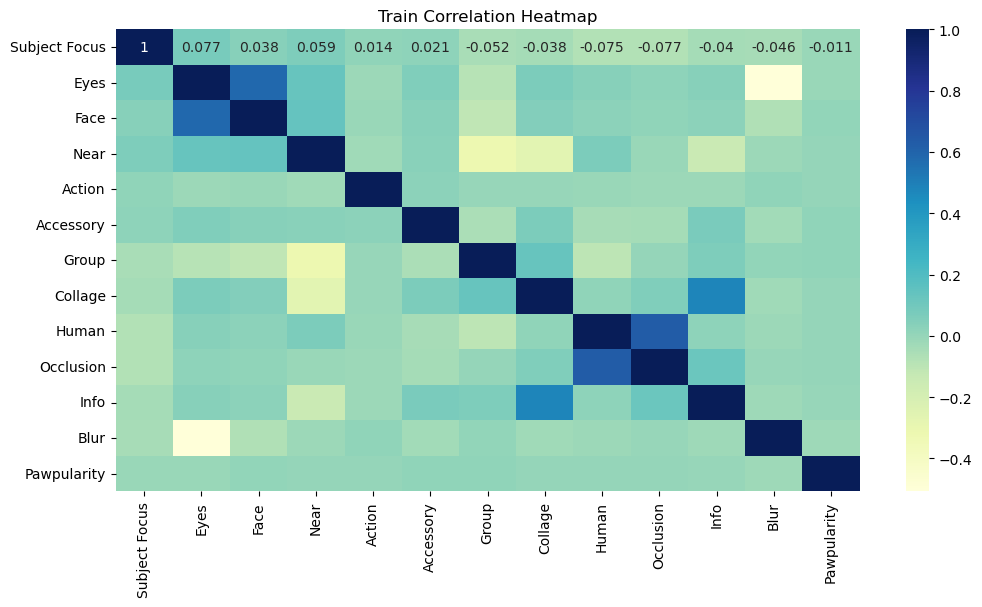

In [16]:
# Plot correlation heatmap
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(train_df.iloc[:].corr(), annot=True, cmap='YlGnBu')
heatmap.set_title('Train Correlation Heatmap')

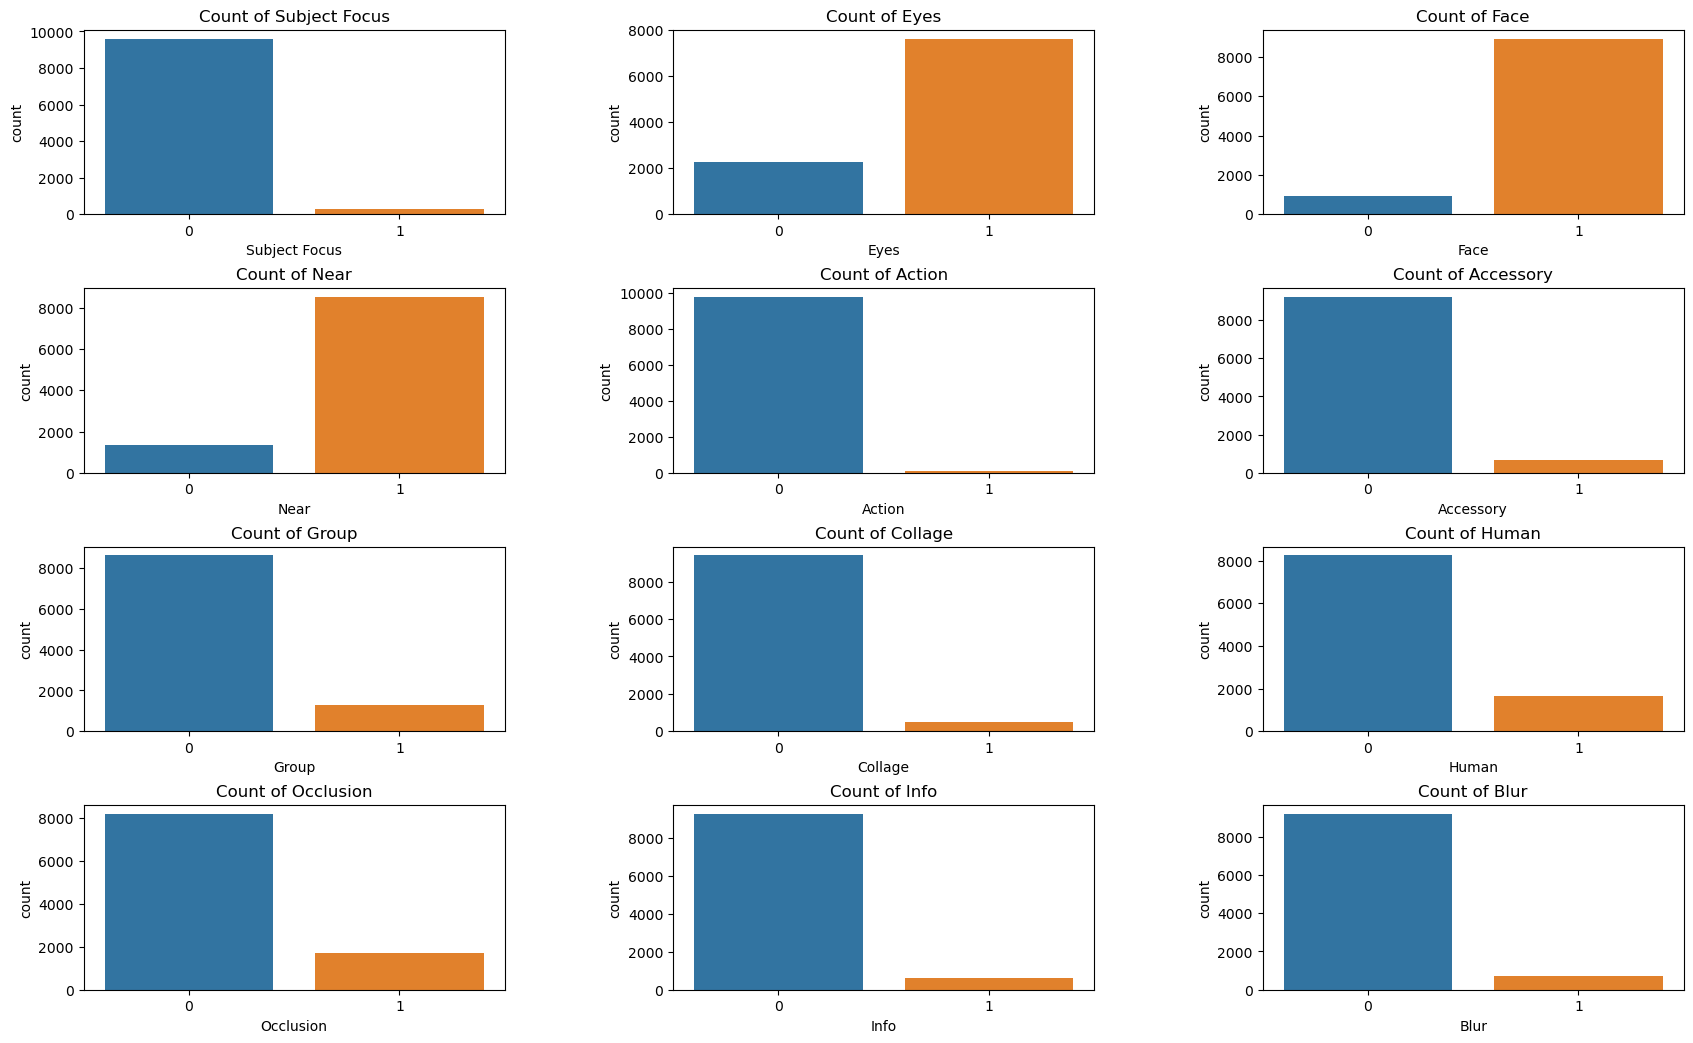

In [17]:
# Plot the count of every feature
columns= train_df.columns
i=0
j=0
k=0
fig, axs = plt.subplots(4, 3, figsize=(20,12))
for col in columns: 
    if (k < len(columns)-1) and (i!= 4):
        sns.countplot(data = train_df, x = col,ax = axs[i,j])
        axs[i,j].set_title(f'Count of {columns[k]}')
        if j==2:
            i+=1
            j=0
        else:
            j+=1
        k+=1
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()


In [18]:
# Statistics summary
train_df.describe()

Subject Focus         Eyes         Face         Near       Action  \
count    9885.000000  9885.000000  9885.000000  9885.000000  9885.000000   
mean        0.027618     0.772281     0.903794     0.861507     0.009914   
std         0.163883     0.419381     0.294889     0.345434     0.099079   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     1.000000     1.000000     1.000000     0.000000   
50%         0.000000     1.000000     1.000000     1.000000     0.000000   
75%         0.000000     1.000000     1.000000     1.000000     0.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

         Accessory        Group      Collage        Human    Occlusion  \
count  9885.000000  9885.000000  9885.000000  9885.000000  9885.000000   
mean      0.067678     0.129287     0.049064     0.165908     0.171472   
std       0.251206     0.335534     0.216013     0.372017     0.376940   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Info         Blur  Pawpularity  
count  9885.000000  9885.000000  9885.000000  
mean      0.060799     0.070612    38.049975  
std       0.238974     0.256189    20.599055  
min       0.000000     0.000000     1.000000  
25%       0.000000     0.000000    25.000000  
50%       0.000000     0.000000    33.000000  
75%       0.000000     0.000000    46.000000  
max       1.000000     1.000000   100.000000

/Users/roddick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


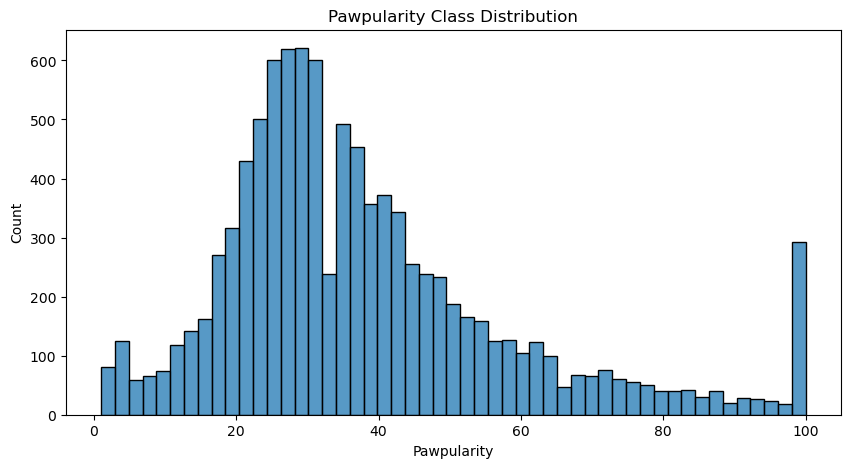

In [19]:
# Plot the target class distribution

# convert the labels array to a pandas dataframe
labels_df = pd.DataFrame(train_df['Pawpularity'], columns =['Pawpularity'])
# histogram
plt.figure(figsize=(10,5))
sns.histplot(data= labels_df, stat= 'count', x='Pawpularity')
plt.title('Pawpularity Class Distribution')
plt.xlabel("Pawpularity");

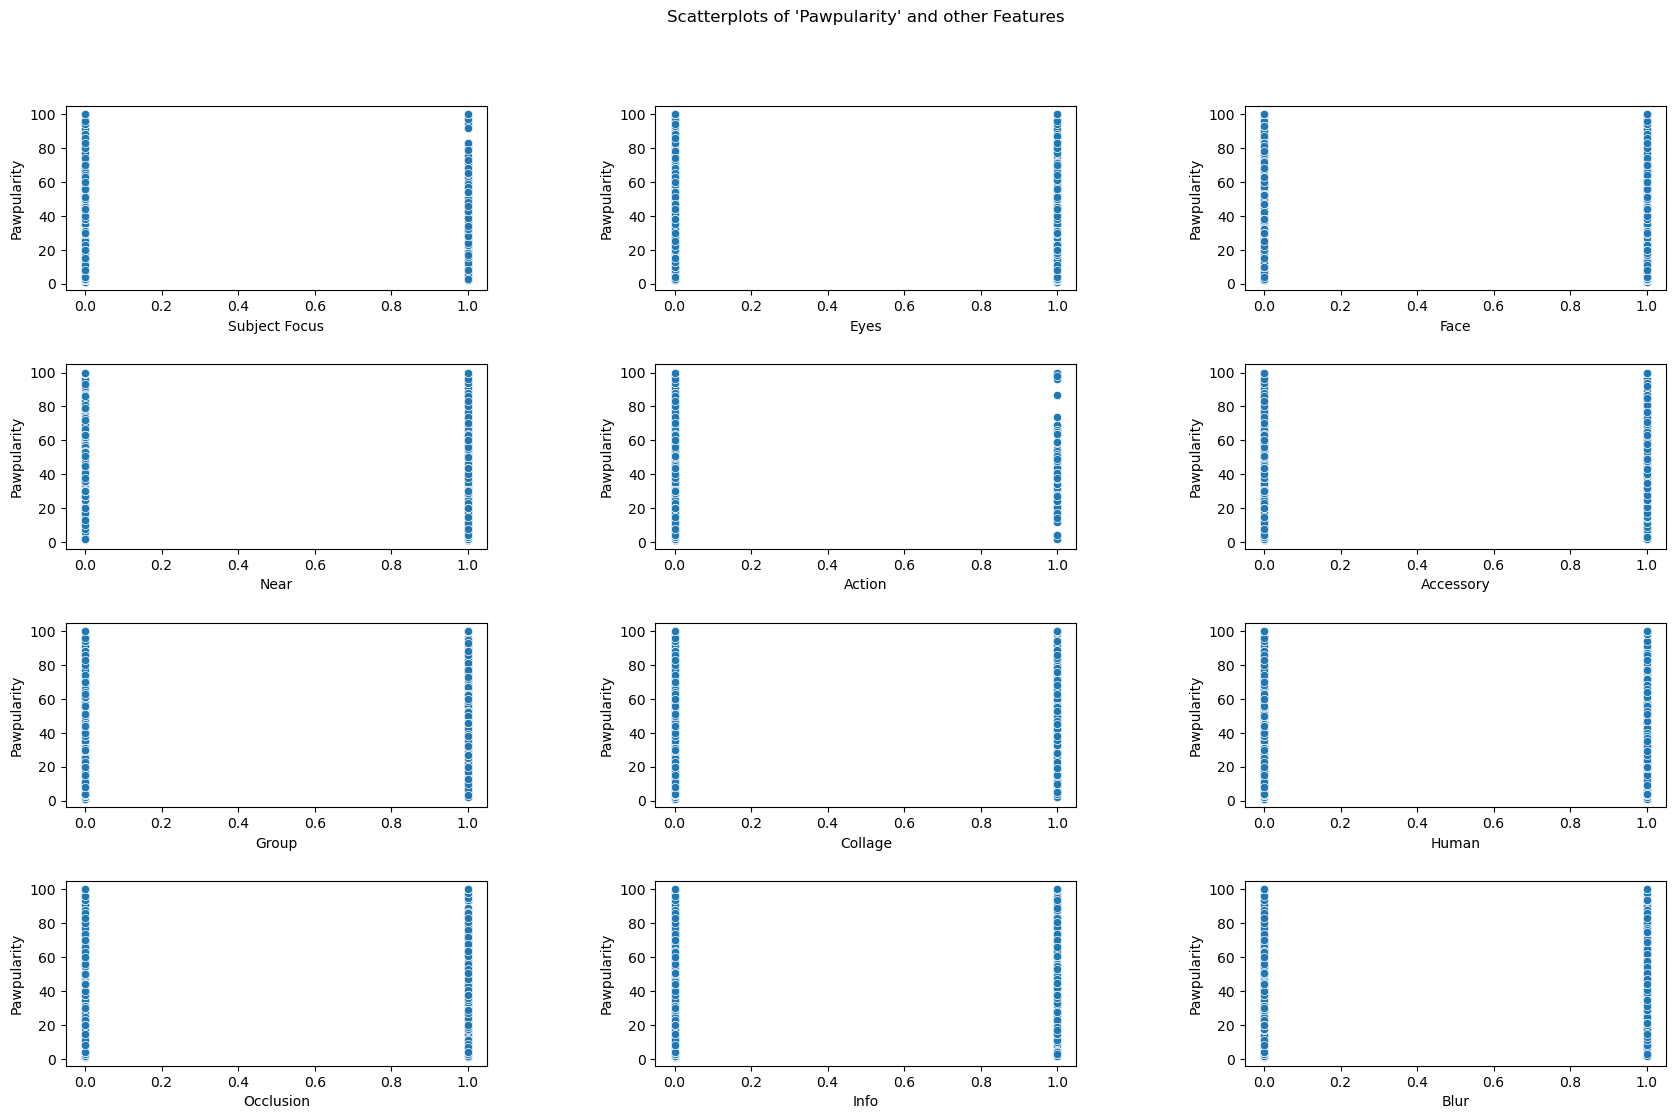

In [20]:
# Scatterplots of 'Pawpularity' and other features
columns= train_df.columns
i=0
j=0
k=0
fig, axs = plt.subplots(4, 3, figsize=(20,12))
for col in columns: 
    if (k < len(columns)-1) and (i!= 4):
        sns.scatterplot(data = train_df, x = col,y= 'Pawpularity',ax = axs[i,j])
        if j==2:
            i+=1
            j=0
        else:
            j+=1
        k+=1
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.suptitle('Scatterplots of \'Pawpularity\' and other Features')
plt.show()


### Step 4: Preprocess Data

In [21]:
# Data augmentation Class - includes class variables we can access throughout
class CF :
    resize_flag = True
    image_size = [224, 224]
    brightness_flag = False
    bright = 0.5
    contrast_flag = False
    contrast = [0.5, 1.5]
    hue_flag = False
    hue = 0.1
    sat_flag = False
    sat = [0.5, 1.5]
    flip_lr_flag = False
    flip_ud_flag = False
    zoom_flag = False
    zoom = [0.5, 0.25]
    def __repr__(self):
        config_string = "\n resize_flag : " + str(self.resize_flag) + ", image_size : " + ' '.join(str(size) for size in self.image_size)
        config_string += "\n brightness_flag : " + str(self.brightness_flag) + ", max_delta : " + str(self.bright)
        config_string += "\n contrast_flag : " + str(self.contrast_flag) +", min / max : " + ' '.join(str(c) for c in self.contrast)
        config_string += "\n hue_flag : " + str(self.hue_flag) + ", max_delta : " + str(self.hue)
        config_string += "\n sat_flag : " + str(self.sat) + ", min / max : " + ' '.join(str(s) for s in self.sat)
        config_string += "\n flip_lr_flag : " + str(self.flip_lr_flag)
        config_string += "\n flip_ud_flag : " + str(self.flip_ud_flag)
        config_string += "\n zoom_flag : " + str(self.zoom_flag) +", min / max : " + ' '.join(str(z) for z in self.zoom)

        return config_string

In [22]:
# train, validation, and test data
train_df = train_df.reset_index()
labels = list(train_df['Pawpularity']/1.0)
train_files, test_files, labels_train, labels_test = train_test_split(new_file_names, labels, test_size=0.2, random_state=137)
train_files, val_files, labels_train, labels_val = train_test_split(train_files, labels_train, test_size=0.2, random_state=137)

In [23]:
# Function to perform data transformation and augmentation
def process_file_names(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    
    # Image augmentation - Apply any true preprocessing feature
    if CF.resize_flag == True :        
        img = tf.image.resize(img, CF.image_size) 
    if CF.brightness_flag == True :
        img = tf.image.random_brightness(img, max_delta = CF.bright)
    if CF.contrast_flag == True :
        img = tf.image.random_contrast(img, CF.contrast[0], CF.contrast[1])
    if CF.hue_flag == True :
        img = tf.image.random_hue(img, max_delta = CF.hue)
    if CF.sat_flag == True :
        img = tf.image.random_saturation(img, CF.sat[0], CF.sat[1])        
    if CF.flip_lr_flag == True :
        img = tf.image.random_flip_left_right(img)
    if CF.flip_ud_flag == True :
        img = tf.image.random_flip_up_down(img)
     
    # rescale image by dividing each pixel by 255.0 
    img = img / 255.0
    
    # rescale labels so between 0 and 1
    label = label/100.01
    
    return img, label

In [24]:
# Print the current configuration modifications on the originals
print(CF().__repr__())


 resize_flag : True, image_size : 224 224
 brightness_flag : False, max_delta : 0.5
 contrast_flag : False, min / max : 0.5 1.5
 hue_flag : False, max_delta : 0.1
 sat_flag : [0.5, 1.5], min / max : 0.5 1.5
 flip_lr_flag : False
 flip_ud_flag : False
 zoom_flag : False, min / max : 0.5 0.25


In [25]:
# Processing  file names in the test and validation sets without data augmentation
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, labels_test))
test_dataset = test_dataset.map(process_file_names)

val_dataset = tf.data.Dataset.from_tensor_slices((val_files, labels_val))
val_dataset = val_dataset.map(process_file_names)

In [26]:
# Turn on all flags for data augmentation
CF.brightness_flag = True
CF.contrast_flag = True
CF.hue_flag = True
CF.sat_flag = True
CF.flip_lr_flag = True
CF.flip_ud_flag = True

# Print the current configuration modifications on the originals
print(CF().__repr__())



 resize_flag : True, image_size : 224 224
 brightness_flag : True, max_delta : 0.5
 contrast_flag : True, min / max : 0.5 1.5
 hue_flag : True, max_delta : 0.1
 sat_flag : [0.5, 1.5], min / max : 0.5 1.5
 flip_lr_flag : True
 flip_ud_flag : True
 zoom_flag : False, min / max : 0.5 0.25


In [27]:
# processing file names in the train set with data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, labels_train))
train_dataset = train_dataset.map(process_file_names)

In [28]:
# Configuring performance
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    return ds
    
train_dataset = configure_for_performance(train_dataset)
val_dataset = configure_for_performance(val_dataset)
test_dataset = configure_for_performance(test_dataset)

In [29]:
# Show the modified images in the specified batch data set
def show_tfbatch_images(dataset) :
    
    for images, labels in dataset.take(1):  # only take first element of dataset
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()

    nrows, ncols = 5,5 #print first 25 images
    f, axs = plt.subplots(nrows, ncols, figsize=(30,20))
    for i in range(nrows):
        for j in range(ncols):
            indx = i*ncols+j
            axs[i,j].imshow(array_to_img(numpy_images[indx]))
            axs[i,j].title.set_text('Pawpularity Score = ' + str( round (numpy_labels[indx] * 100, 2))) 
    return

2024-04-15 10:41:18.788229: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


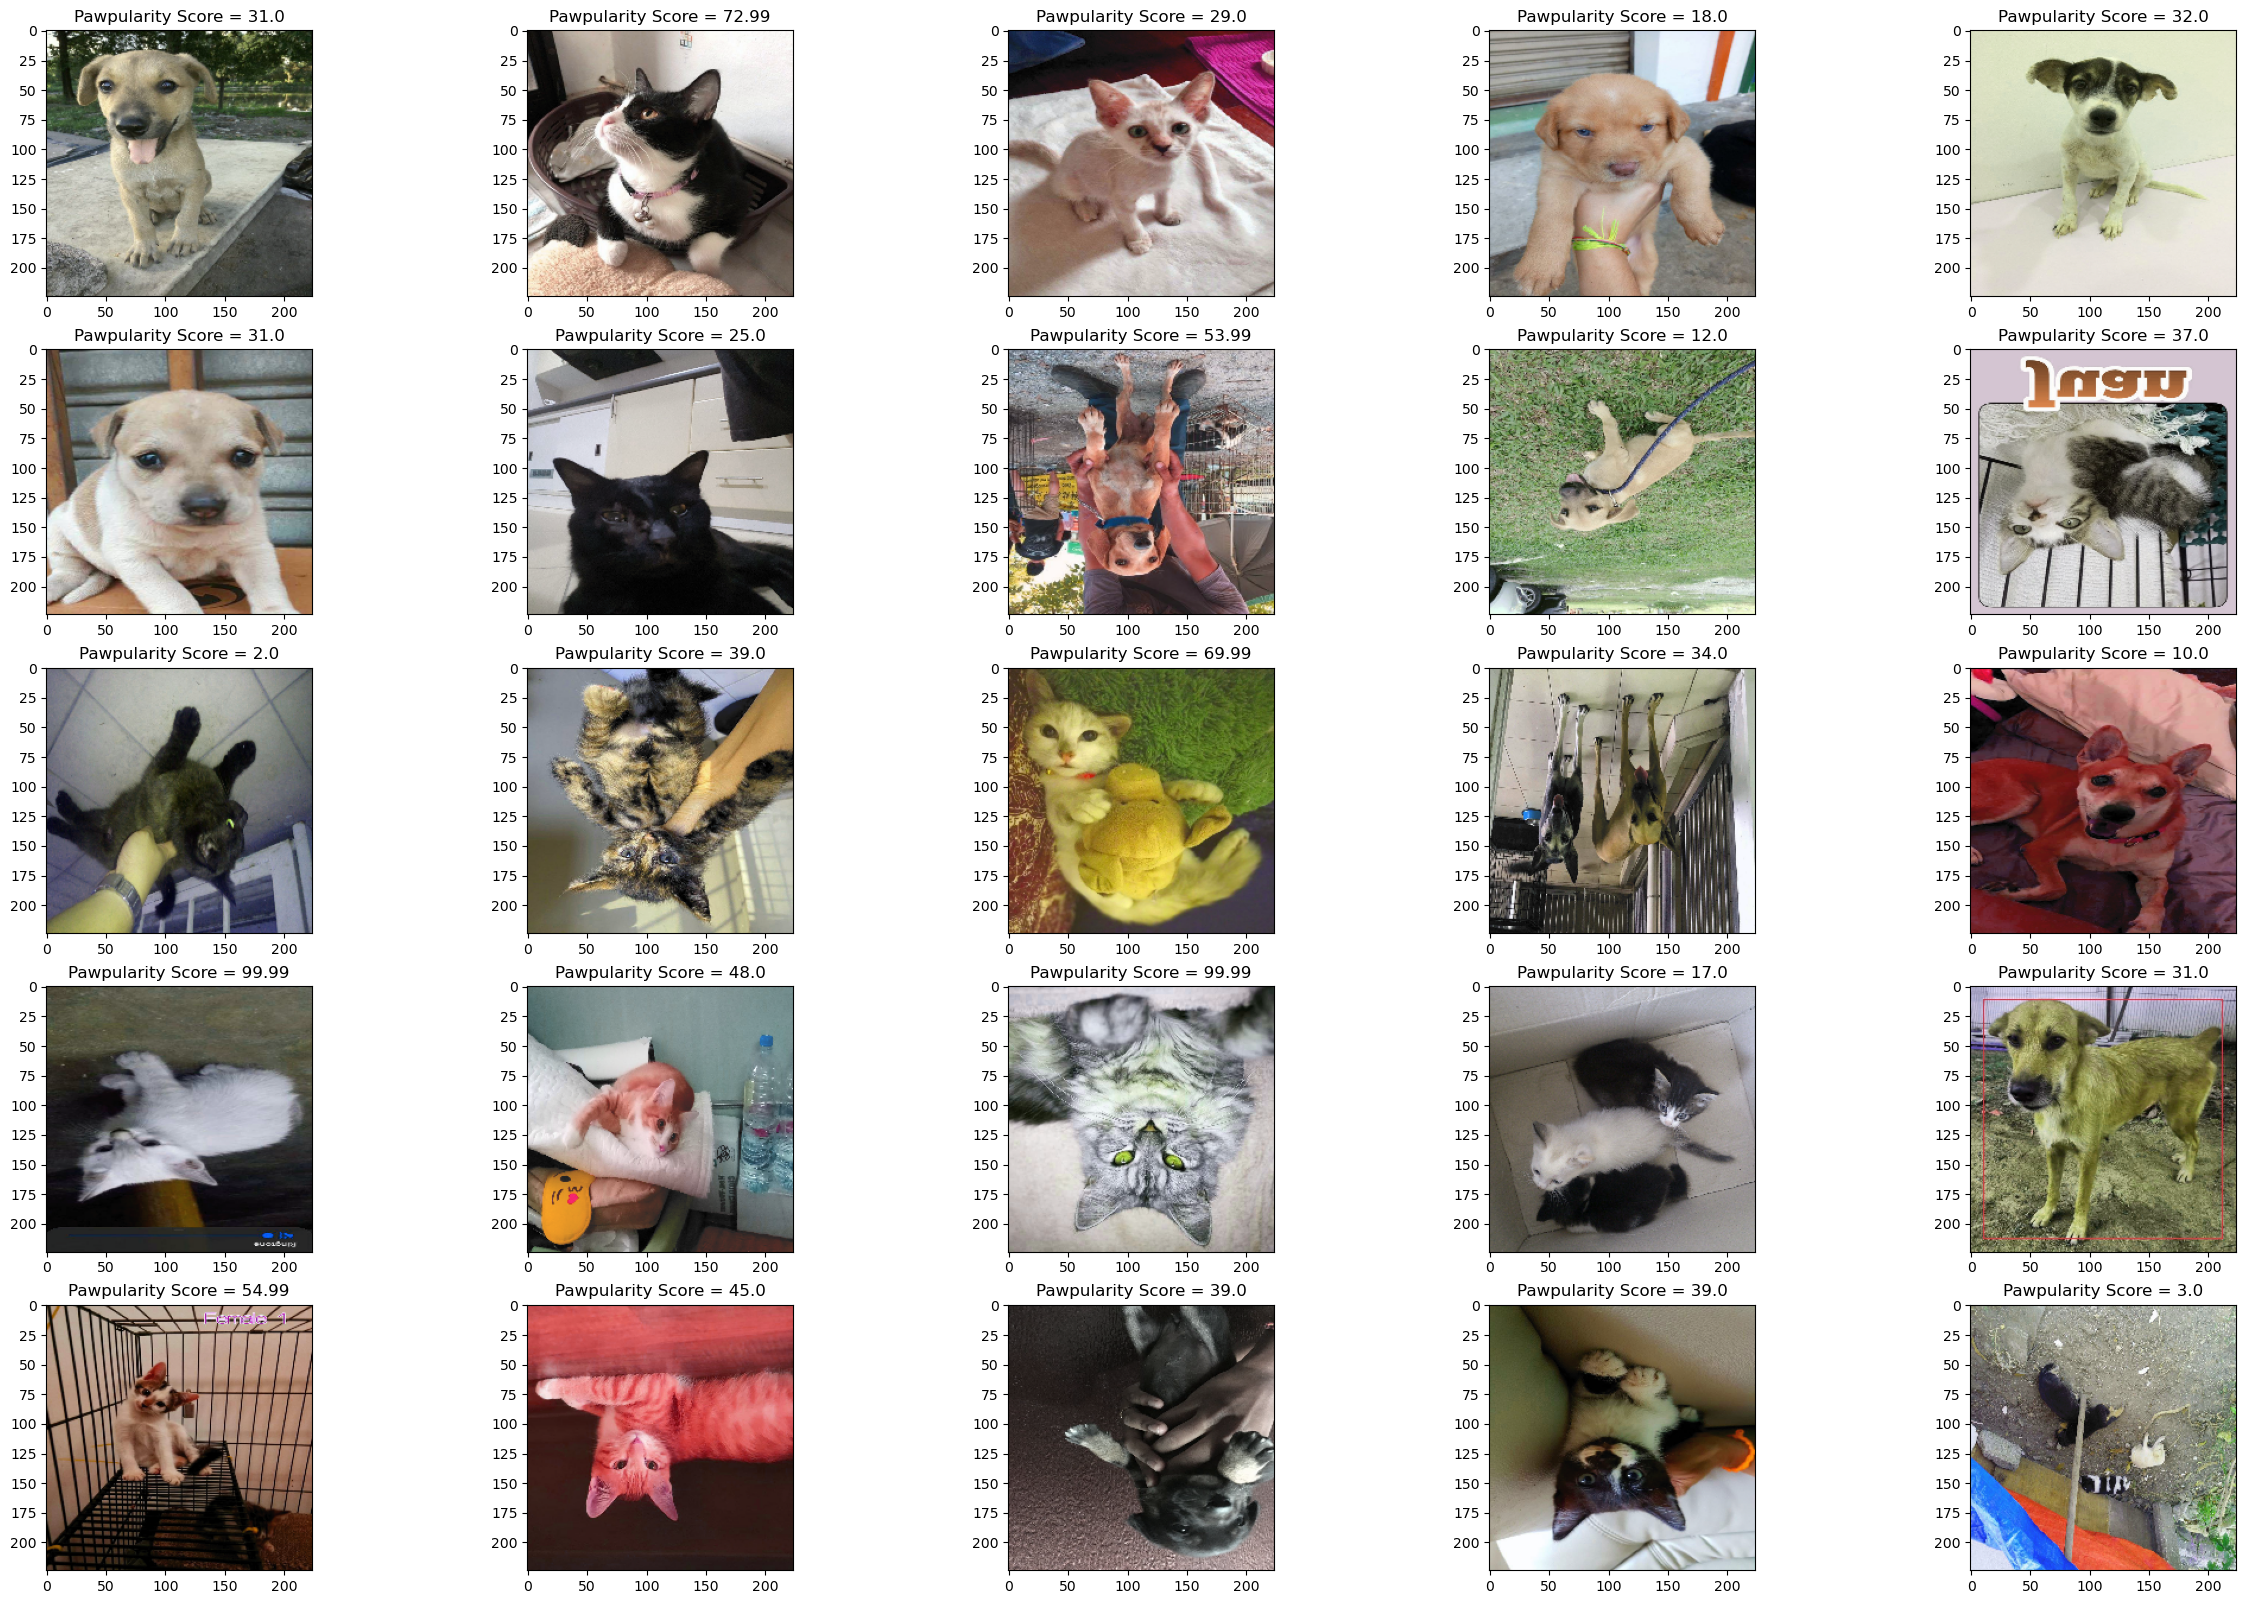

In [30]:
show_tfbatch_images(train_dataset)

In [31]:
# train and validation data for model with metadata
labels2 = list(train_df['Pawpularity']/100.01)

train_files2, test_files2, metadata_train, metadata_test, labels_train2, labels_test2 = train_test_split(new_file_names, new_metadata, labels2, test_size=0.2, random_state=137)
train_files2, val_files2, metadata_train, metadata_val, labels_train2, labels_val2 = train_test_split(train_files2, metadata_train, labels_train2, test_size=0.2, random_state=137)

def process_file_names_train(file_name, metadata_row, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = tf.keras.applications.efficientnet.preprocess_input(img) 
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.95, 1.05)
    img = tf.image.random_contrast(img, 0.95, 1.05)
    
    return img/255., metadata_row, label

def process_file_names_val_test(file_name, metadata_row, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = tf.keras.applications.efficientnet.preprocess_input(img) 
    
    return img/255., metadata_row, label


In [32]:
# Preprocessing for model with metadata
train_dataset2 = tf.data.Dataset.from_tensor_slices((train_files2, metadata_train, labels_train2))
train_dataset2 = train_dataset2.map(process_file_names_train)
train_dataset2 = train_dataset2.map(lambda image_lambda, metadata_lambda, label: ({'image_input': image_lambda, 'metadata_input': metadata_lambda}, label))

val_dataset2 = tf.data.Dataset.from_tensor_slices((val_files2, metadata_val, labels_val2))
val_dataset2 = val_dataset2.map(process_file_names_val_test)
val_dataset2 = val_dataset2.map(lambda image_lambda, metadata_lambda, label: ({'image_input': image_lambda, 'metadata_input': metadata_lambda}, label))

test_dataset2 = tf.data.Dataset.from_tensor_slices((test_files2, metadata_test, labels_test2))
test_dataset2 = test_dataset2.map(process_file_names_val_test)
test_dataset2 = test_dataset2.map(lambda image_lambda, metadata_lambda, label: ({'image_input': image_lambda, 'metadata_input': metadata_lambda}, label))

# configure performance
train_dataset2 = configure_for_performance(train_dataset2)

val_dataset2 = configure_for_performance(val_dataset2)

test_dataset2 = configure_for_performance(test_dataset2)

In [33]:
# Functions for Transfer Learning Model preprocessing
def process_fileNames_train(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    
    # drop this for val and test data
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_saturation(img, 0.95, 1.05)
    img = tf.image.random_contrast(img, 0.95, 1.05)
    
    return img, label/100.01

def process_fileNames_val(file_name, label):
    image_string = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(image_string, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    #img = tf.keras.applications.efficientnet.preprocess_input(img) 
    
    return img, label/100.01

In [34]:
# Preprocessing for Transfer Learning Model

train_dataset3 = tf.data.Dataset.from_tensor_slices((train_files, labels_train))
train_dataset3 = train_dataset3.map(process_fileNames_train)

val_dataset3 = tf.data.Dataset.from_tensor_slices((val_files, labels_val))
val_dataset3 = val_dataset3.map(process_fileNames_val)

test_dataset3 = tf.data.Dataset.from_tensor_slices((test_files, labels_test))
test_dataset3 = test_dataset3.map(process_fileNames_val)

# configure performance
train_dataset3 = configure_for_performance(train_dataset3)

val_dataset3 = configure_for_performance(val_dataset3)

test_dataset3 = configure_for_performance(test_dataset3)

### Step 5: Modeling and Evaluation

### <span style="color:chocolate"> Baseline Model  </span>

#### Dummy Model

Predict Mean Pawpularity Score

In [35]:
train_df = train_df.set_index('Id')
# Baseline: Mean Pawpularity Score
y = train_df['Pawpularity'].to_numpy()
X = train_df.drop(columns=['Pawpularity']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=137)

In [36]:
# Dummy model
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)
np.sqrt(mean_squared_error(y_pred, y_test))

20.42747312170261

In [37]:
# Cross validation score
dummy_model = DummyRegressor(strategy='mean')
scores = cross_val_score(dummy_model, X, y, cv=10, scoring='neg_root_mean_squared_error')
print("%0.2f RMSE with a standard deviation of %0.2f" % (-scores.mean(), scores.std()))

20.59 RMSE with a standard deviation of 0.52


### <span style="color:chocolate"> Random Forest  </span>

In [38]:
# Random Forest model - Metadata only
rf_regressor = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(rf_regressor, X, y, cv=10, scoring='neg_root_mean_squared_error')
print("%0.2f RMSE with a standard deviation of %0.2f" % (-scores.mean(), scores.std()))

20.78 RMSE with a standard deviation of 0.55


### <span style="color:chocolate"> Improvement on Baseline Model  </span>

### ResNet

In [39]:
# Define residual layer

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False),
            tf.keras.layers.BatchNormalization()
        ]
        # If strides > 1 need to use 1D convolutions with long stride to resize image so they can be added
        if strides == 1:
            self.skip_layers = []
        else:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False),
                tf.keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        skip_z = inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        # either return a(z) + skip_z or a(z + skip_z)
        return self.activation(z + skip_z)

In [40]:
# Define ResNet

def build_resnet():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False, input_shape=[224,224,3]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
    prev_filters = 128
    for filters in [64, 64, 128, 256, 512]:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters


    model.add(tf.keras.layers.GlobalAvgPool2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0011,
        decay_steps=50, decay_rate=0.77,
        staircase=True)

    # lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    #     initial_learning_rate=0.005,
    #     decay_steps=99,
    #     power=0.1)

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])    

    return model


In [41]:
# build model
resnet = build_resnet()

# use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history_rn = resnet.fit(train_dataset,
                  epochs=50,
                  validation_data=val_dataset,
                  verbose=1,
                  callbacks=[early_stopping_callback])

Epoch 1/50
198/198 [==============================] - 62s 289ms/step - loss: 0.7144 - root_mean_squared_error: 0.2441 - val_loss: 0.6709 - val_root_mean_squared_error: 0.2118
Epoch 2/50
198/198 [==============================] - 54s 273ms/step - loss: 0.6802 - root_mean_squared_error: 0.2211 - val_loss: 0.6728 - val_root_mean_squared_error: 0.2106
Epoch 3/50
198/198 [==============================] - 54s 275ms/step - loss: 0.6723 - root_mean_squared_error: 0.2134 - val_loss: 0.6671 - val_root_mean_squared_error: 0.2072
Epoch 4/50
198/198 [==============================] - 55s 278ms/step - loss: 0.6681 - root_mean_squared_error: 0.2096 - val_loss: 0.6667 - val_root_mean_squared_error: 0.2068
Epoch 5/50
198/198 [==============================] - 56s 282ms/step - loss: 0.6658 - root_mean_squared_error: 0.2073 - val_loss: 0.6668 - val_root_mean_squared_error: 0.2069
Epoch 6/50
198/198 [==============================] - 56s 282ms/step - loss: 0.6657 - root_mean_squared_error: 0.2072 - val_l

In [42]:
resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 residual_unit (ResidualUni  (None, 28, 28, 64)        78592     
 t)                                                              
                                                        

In [43]:
resnet_hist = pd.DataFrame(history_rn.history)
display(resnet_hist)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   0.714431                 0.244127  0.670903                     0.211843
1   0.680248                 0.221108  0.672762                     0.210562
2   0.672304                 0.213377  0.667061                     0.207222
3   0.668075                 0.209576  0.666679                     0.206821
4   0.665843                 0.207263  0.666791                     0.206936
5   0.665697                 0.207249  0.666661                     0.206774
6   0.667587                 0.209041  0.666606                     0.206659
7   0.666222                 0.207576  0.666602                     0.206673
8   0.665584                 0.207155  0.666614                     0.206681
9   0.665022                 0.206633  0.666592                     0.206667
10  0.664956                 0.206550  0.666591                     0.206663
11  0.666449                 0.207903  0.666627                     0.206685
12  0.664485                 0.205824  0.666606                     0.206674
13  0.666523                 0.207889  0.666575                     0.206644
14  0.666138                 0.207578  0.666614                     0.206678
15  0.666978                 0.208495  0.666615                     0.206691
16  0.665335                 0.206498  0.666623                     0.206695
17  0.665590                 0.207175  0.666618                     0.206687
18  0.664073                 0.205580  0.666603                     0.206661

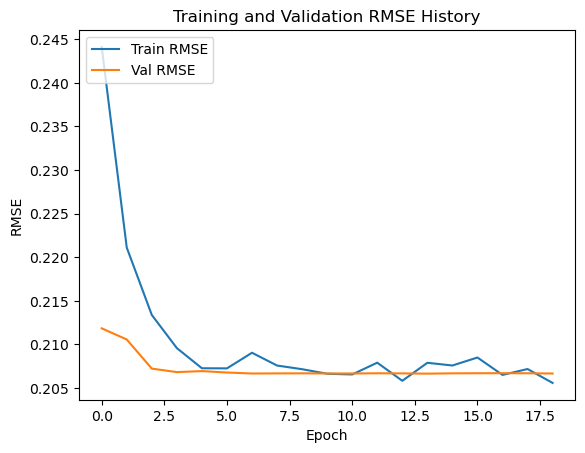

In [44]:
# Plot the training & validation RMSE

plt.rcdefaults() # reset to rc default values
plt.plot(resnet_hist['root_mean_squared_error'])
plt.plot(resnet_hist['val_root_mean_squared_error'])

plt.title("Training and Validation RMSE History")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.legend(["Train RMSE", "Val RMSE"], loc ="upper left")

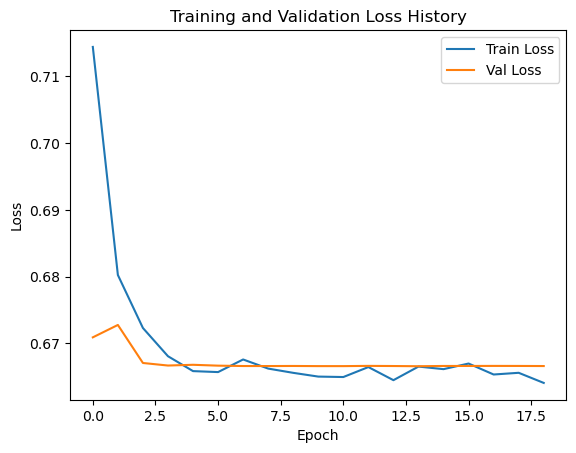

In [45]:
# Plot the training & validation loss

plt.plot(resnet_hist['loss'])
plt.plot(resnet_hist['val_loss'])

plt.title("Training and Validation Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend(["Train Loss", "Val Loss"], loc ="upper right")

### ResNet Evaluation

In [46]:
# Pawpularity scores 
pawp_scores = resnet.evaluate(test_dataset, verbose = 1) 
print('Test loss:', pawp_scores[0]) 
print('Test RMSE:', pawp_scores[1])

62/62 [==============================] - 5s 66ms/step - loss: 0.6640 - root_mean_squared_error: 0.2048
Test loss: 0.6639952659606934
Test RMSE: 0.20476514101028442


### Hyperparameter Tuning Table 1

EXP #  | DECAY TYPE | INITIAL LEARNING RATE | DECAY STEP | DECAY RATE / POWER| TRAIN RMSE | VAL RMSE | TEST RMSE
-|-|-|-|-|-|-|-
1|Exponential|0.005|99|0.95|20.59|20.67|20.47
2|Exponential|<font color="red">0.001</font>|99|0.95|15.53|23.21|20.63
3|Exponential|0.005|<font color="red">50</font>|0.95|20.77|20.87|20.59
4|Exponential|0.005|99|<font color="red">0.75</font>|20.63|20.65|20.44
5|Exponential|0.0011|50|0.75|19.57|20.73|20.57
6|Polynomial|0.005|99|0.5|20.64|20.71|20.55
7|Polynomial|<font color="red">0.001</font>|99|0.5|15.66|23.31|20.39
8|Polynomial|0.005|<font color="red">50</font>|0.5|20.75|20.72|20.53
9|Polynomial|0.005|99|<font color="red">0.1</font>|21.24|20.65|20.46

### ResNet with Metadata

In [47]:
def build_resnet_backbone():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False, input_shape=[224,224,3]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
    prev_filters = 128
    for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters


    model.add(tf.keras.layers.GlobalAvgPool2D())
    model.add(tf.keras.layers.Flatten())


    return model

image_backbone = build_resnet_backbone()

image_input = tf.keras.layers.Input(shape=[224,224,3], name='image_input')
metadata_input = tf.keras.layers.Input(shape=[12], name='metadata_input')

image_processed = image_backbone(image_input)

x = tf.keras.layers.concatenate([image_processed, metadata_input])

x = tf.keras.layers.Dense(512, activation='tanh')(x)

output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=[image_input, metadata_input], outputs=output)

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 512)                  2130604   ['image_input[0][0]']         
                                                          8                                       
                                                                                                  
 metadata_input (InputLayer  [(None, 12)]                 0         []                            
 )                                                                                                
                                                                                              

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,restore_best_weights=True)


# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(0.0000005, 1000, warmup_target=3e-6, warmup_steps=500, alpha=1e-7)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.000001,
    decay_steps=128, decay_rate=0.95,
    staircase=True)

model.compile(loss="binary_crossentropy", 
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


predictor = model.fit(train_dataset2,
                      epochs=10, 
                      validation_data = val_dataset2,
                      callbacks=[early_stopping])

Epoch 1/10
198/198 [==============================] - 127s 609ms/step - loss: 0.7302 - root_mean_squared_error: 0.2720 - val_loss: 0.6785 - val_root_mean_squared_error: 0.2205
Epoch 2/10
198/198 [==============================] - 120s 608ms/step - loss: 0.6682 - root_mean_squared_error: 0.2110 - val_loss: 0.6726 - val_root_mean_squared_error: 0.2134
Epoch 3/10
198/198 [==============================] - 122s 616ms/step - loss: 0.6653 - root_mean_squared_error: 0.2078 - val_loss: 0.6731 - val_root_mean_squared_error: 0.2140
Epoch 4/10
198/198 [==============================] - 123s 619ms/step - loss: 0.6644 - root_mean_squared_error: 0.2067 - val_loss: 0.6730 - val_root_mean_squared_error: 0.2139
Epoch 5/10
198/198 [==============================] - 123s 622ms/step - loss: 0.6635 - root_mean_squared_error: 0.2057 - val_loss: 0.6733 - val_root_mean_squared_error: 0.2141
Epoch 6/10
198/198 [==============================] - 124s 625ms/step - loss: 0.6616 - root_mean_squared_error: 0.2036 -

In [50]:
model_hist = pd.DataFrame(predictor.history)
display(model_hist)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0  0.730212                 0.271952  0.678483                     0.220507
1  0.668217                 0.211039  0.672564                     0.213373
2  0.665340                 0.207796  0.673106                     0.213962
3  0.664371                 0.206688  0.673030                     0.213858
4  0.663497                 0.205744  0.673302                     0.214134
5  0.661634                 0.203583  0.673010                     0.213850
6  0.660586                 0.202372  0.672997                     0.213776

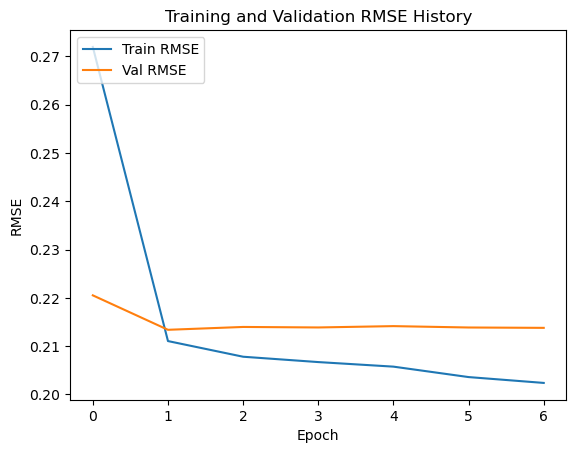

In [51]:
# Plot the training & validation RMSE

plt.rcdefaults() # reset to rc default values
plt.plot(model_hist['root_mean_squared_error'])
plt.plot(model_hist['val_root_mean_squared_error'])

plt.title("Training and Validation RMSE History")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.legend(["Train RMSE", "Val RMSE"], loc ="upper left")

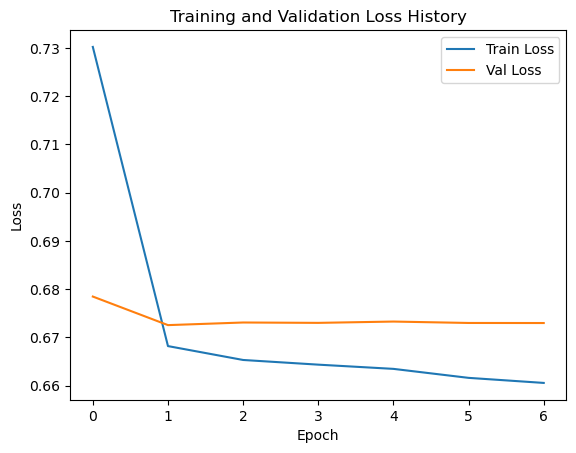

In [52]:
# Plot the training & validation loss

plt.plot(model_hist['loss'])
plt.plot(model_hist['val_loss'])

plt.title("Training and Validation Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend(["Train Loss", "Val Loss"], loc ="upper right")

### ResNet with Metadata Evaluation

In [53]:
# Pawpularity scores 
pawp_scores2 = model.evaluate(test_dataset2, verbose = 1) 
print('Test loss:', pawp_scores2[0]) 
print('Test RMSE:', pawp_scores2[1])

62/62 [==============================] - 10s 151ms/step - loss: 0.6682 - root_mean_squared_error: 0.2095
Test loss: 0.6681602597236633
Test RMSE: 0.20953688025474548


### Hyperparameter Tuning Table 2

EXP #  | # of NEURONS IN LAST LAYER | ACTIVATION FUNCTION | DECAY TYPE | INITIAL LEARNING RATE | TRAIN RMSE | VAL RMSE | TEST RMSE
-|-|-|-|-|-|-|-
1|512|tanh|Cosine|0.0000001|19.04|21.95|21.19
2|<font color="red">128</font>|tanh|Cosine|0.0000001|19.32|21.92|21.59
3|512|<font color="red">ReLU</font>|Cosine|0.0000001|18.72|22.09|21.64
4|512|tanh|Cosine|<font color="red">0.000001</font>|18.53|21.74|21.48
5|512|tanh|Exponential|0.0000001|20.70|21.56|21.45
6|<font color="red">128</font>|tanh|Exponential|0.0000001|22.13|22.01|21.86
7|512|<font color="red">ReLU</font>|Exponential|0.0000001|21.02|21.96|21.76
8|512|tanh|Exponential|<font color="red">0.000001</font>|19.17|21.71|21.50

### Transfer Learning Model

#### EfficientNetB0

In [55]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, pooling='avg')
base_model.trainable = False

transfer_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.Dense(units = 16, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units = 1, activation="sigmoid")
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,restore_best_weights=True)

    
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-4, 10000, warmup_target=1e-3, warmup_steps=1000, alpha=1e-4)

transfer_model.compile(loss="binary_crossentropy", 
              optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr_schedule), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

transfer_predictor = transfer_model.fit(train_dataset3,
                      epochs=50, 
                      validation_data = val_dataset3,
                      callbacks=[early_stopping])

Epoch 1/50
198/198 [==============================] - 54s 260ms/step - loss: 0.8089 - root_mean_squared_error: 0.3051 - val_loss: 0.6903 - val_root_mean_squared_error: 0.2318
Epoch 2/50
198/198 [==============================] - 50s 255ms/step - loss: 0.7007 - root_mean_squared_error: 0.2377 - val_loss: 0.6797 - val_root_mean_squared_error: 0.2198
Epoch 3/50
198/198 [==============================] - 50s 254ms/step - loss: 0.6594 - root_mean_squared_error: 0.1992 - val_loss: 0.6671 - val_root_mean_squared_error: 0.2003
Epoch 4/50
198/198 [==============================] - 50s 254ms/step - loss: 0.6490 - root_mean_squared_error: 0.1878 - val_loss: 0.6609 - val_root_mean_squared_error: 0.1954
Epoch 5/50
198/198 [==============================] - 50s 255ms/step - loss: 0.6442 - root_mean_squared_error: 0.1814 - val_loss: 0.6586 - val_root_mean_squared_error: 0.1936
Epoch 6/50
198/198 [==============================] - 50s 254ms/step - loss: 0.6404 - root_mean_squared_error: 0.1768 - val_l

In [56]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 16)                20496     
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4070148 (15.53 MB)
Trainable params: 20545 (80.25 KB)
Non-trainable params: 4049603 (15.45 MB)
_________________________________________________________________


In [57]:
transfer_model_hist = pd.DataFrame(transfer_predictor.history)
display(transfer_model_hist)

loss  root_mean_squared_error  val_loss  val_root_mean_squared_error
0   0.808924                 0.305134  0.690282                     0.231780
1   0.700731                 0.237745  0.679657                     0.219759
2   0.659438                 0.199182  0.667072                     0.200313
3   0.649023                 0.187751  0.660875                     0.195398
4   0.644238                 0.181416  0.658621                     0.193587
5   0.640422                 0.176803  0.658482                     0.191659
6   0.638128                 0.173661  0.658132                     0.190843
7   0.633918                 0.168114  0.662476                     0.196900
8   0.633560                 0.167697  0.661951                     0.195328
9   0.631016                 0.164382  0.664069                     0.196860
10  0.629225                 0.161615  0.663663                     0.198968
11  0.626281                 0.157696  0.665772                     0.200319

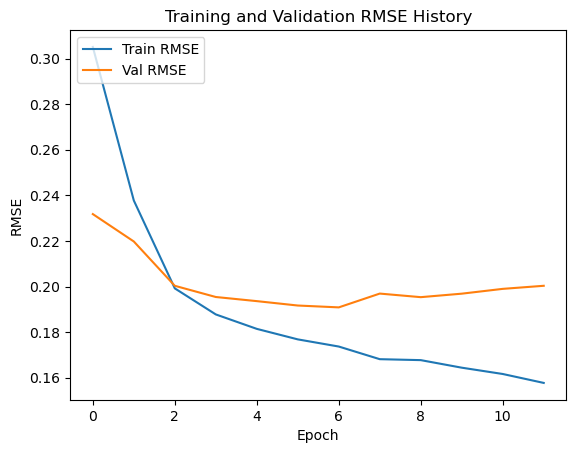

In [58]:
# Plot the training & validation RMSE

plt.rcdefaults() # reset to rc default values
plt.plot(transfer_model_hist['root_mean_squared_error'])
plt.plot(transfer_model_hist['val_root_mean_squared_error'])

plt.title("Training and Validation RMSE History")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.legend(["Train RMSE", "Val RMSE"], loc ="upper left")

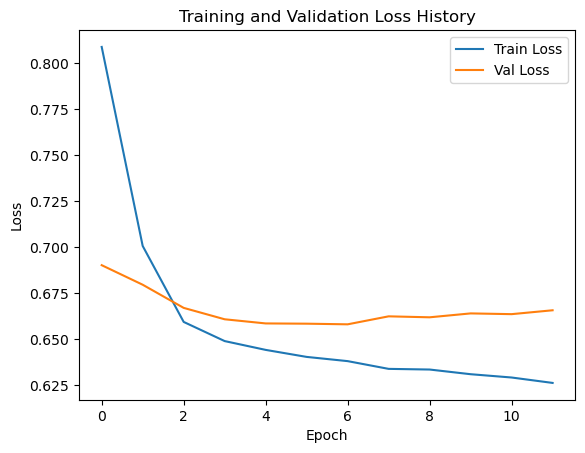

In [59]:
# Plot the training & validation loss

plt.plot(transfer_model_hist['loss'])
plt.plot(transfer_model_hist['val_loss'])

plt.title("Training and Validation Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend(["Train Loss", "Val Loss"], loc ="upper right")

### Transfer Model Evaluation

In [60]:
# Pawpularity scores 
pawp_scores3 = transfer_model.evaluate(test_dataset3, verbose = 1) 
print('Test loss:', pawp_scores3[0]) 
print('Test RMSE:', pawp_scores3[1])

62/62 [==============================] - 15s 221ms/step - loss: 0.6605 - root_mean_squared_error: 0.1943
Test loss: 0.6604811549186707
Test RMSE: 0.19434061646461487


### Step 6: Interpretation

TBD